In [1]:
%matplotlib inline
#import ipywidgets as widgets
#from ipywidgets import interact
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from scipy.spatial.distance import cdist
#from numpy.linalg import inv
import george
from george.kernels import ExpSine2Kernel, ExpSquaredKernel
import astropy
from astropy.io import fits
import lightkurve
import theano
import theano.tensor as tt
import pymc3 as pm
from pymc3.step_methods.hmc import quadpotential
#import exoplanet as xo

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### 1) Load light curve data

In [2]:
filename = '/Users/chrislam/Desktop/epic-246301900/ktwo246301900-c12_llc.fits'
hdul = fits.open(filename)
hdul.info()

Filename: /Users/chrislam/Desktop/epic-246301900/ktwo246301900-c12_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   3862R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (10, 8)   int32   


In [3]:
data = fits.getdata(filename,header=True,ext=1)
df = pd.DataFrame(np.array(data[0]).byteswap().newbyteorder()) # to avoid big-endian/little-endian mixup: https://stackoverflow.com/questions/30283836/creating-pandas-dataframe-from-numpy-array-leads-to-strange-errors
print(df.head())

          TIME  TIMECORR  CADENCENO     SAP_FLUX  SAP_FLUX_ERR       SAP_BKG  \
0  2905.377230  0.005332     136855  614164.8125     22.716827  19529.195312   
1  2905.397662  0.005331     136856  614196.0000     22.708811  19530.005859   
2  2905.418095  0.005329     136857  614179.6250     22.713530  19541.736328   
3  2905.438527  0.005328     136858  614099.5000     22.717106  19533.994141   
4  2905.458959  0.005327     136859  614238.1875     22.723835  19532.445312   

   SAP_BKG_ERR  PDCSAP_FLUX  PDCSAP_FLUX_ERR  SAP_QUALITY  PSF_CENTR1  \
0     7.201994          NaN              NaN       524288         NaN   
1     7.175916  612915.2500        22.353420            0         NaN   
2     7.180060  612892.8125        22.366695            0         NaN   
3     7.191803  612824.8125        22.378389            0         NaN   
4     7.191343  612975.3750        22.391329            0         NaN   

   PSF_CENTR1_ERR  PSF_CENTR2  PSF_CENTR2_ERR  MOM_CENTR1  MOM_CENTR1_ERR  \
0  

3255


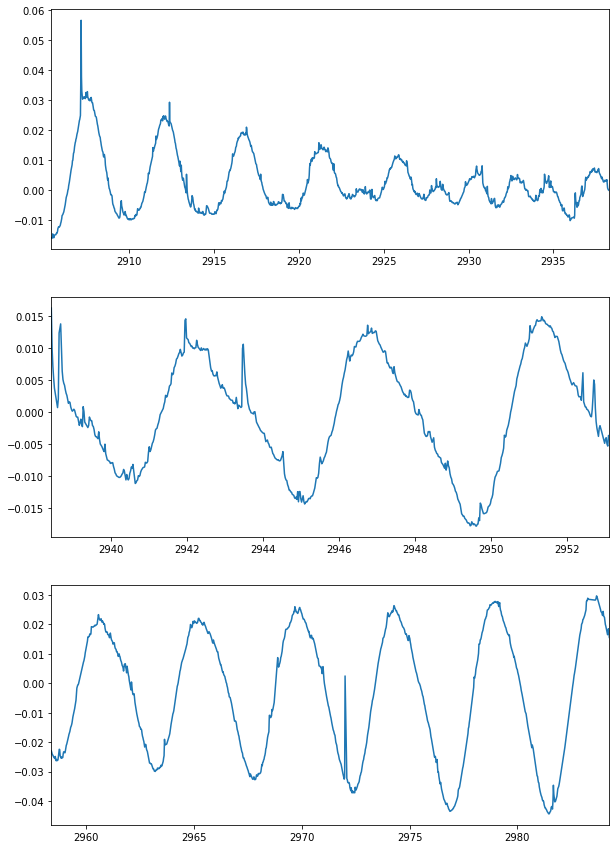

In [4]:
# divide data into pre-flare, post-flare/pre-gap, and post-flare/post-gap
df = pd.DataFrame(np.array(data[0]).byteswap().newbyteorder())
df = df.dropna(subset=['TIME','PDCSAP_FLUX','PDCSAP_FLUX_ERR']) # toss NaNs since they'll create matrices of NaNs
print(len(df))

pre = df.loc[:1611] # next record is the beginning of the flare, so stop here
post = df.loc[1614:2336] # start from after the flare until beginning of the gap in time series data
postgap = df.loc[2337:] # start from end of the gap in data until end of time series data
df_sans_superflare = pd.concat([pre, post, postgap])

plt.figure(figsize=(10,15))
plt.subplot(311)
xobs = np.array(pre["TIME"])
yobs = np.array(pre["PDCSAP_FLUX"])
plt.xlim(min(pre.TIME),max(pre.TIME))
#plt.ylim(590000,660000)
plt.plot(xobs,yobs/np.median(yobs)-1)

plt.subplot(312)
xobs = np.array(post["TIME"])
yobs = np.array(post["PDCSAP_FLUX"])
plt.xlim(min(post.TIME),max(post.TIME))
#plt.ylim(590000,660000)
plt.plot(xobs,yobs/np.median(yobs)-1)

plt.subplot(313)
xobs = np.array(postgap["TIME"])
yobs = np.array(postgap["PDCSAP_FLUX"])
plt.xlim(min(postgap.TIME),max(postgap.TIME))
#plt.ylim(590000,660000)
plt.plot(xobs,yobs/np.median(yobs)-1)
plt.show()

### 2) Load identified flares

In [5]:
path = '/Users/chrislam/Desktop/epic-246301900/'
identified_flares = pd.read_csv(path+'injection-recovery/identified_flares.csv')
print(identified_flares)

flares_pre = identified_flares.loc[identified_flares.tpeak <= np.max(pre.TIME)]
flares_post = identified_flares.loc[(identified_flares.tpeak <= np.max(post.TIME)) & (identified_flares.tpeak > np.max(pre.TIME))]
flares_postgap = identified_flares.loc[identified_flares.tpeak > np.max(post.TIME)]

"""
tpeaks = identified_flares.tpeak
ampls = identified_flares.ampls
fwhms = identified_flares.fwhms
npeaks = len(identified_flares)
"""
tpeaks = flares_pre.tpeak
ampls = flares_pre.ampls
fwhms = flares_pre.fwhms
npeaks = len(flares_pre)

preds = pd.read_csv(path+'injection-recovery/preds.csv')
print(preds)
preds_pre = preds.loc[:len(pre)-1]
preds_post = preds.loc[len(pre)+1:len(pre)+len(post)]
preds_postgap = preds.loc[len(pre)+len(post):]

"""
x = df_sans_superflare.TIME
norm_flux = df.PDCSAP_FLUX/np.median(df.PDCSAP_FLUX) - 1
print(norm_flux)
y = (norm_flux-preds.flux_norm)/np.std(norm_flux-preds.flux_norm) # subtract out GP-modeled spot modulation flux
print(y)
"""
x = pre.TIME
norm_flux = pre.PDCSAP_FLUX/np.median(pre.PDCSAP_FLUX) - 1
#print(len(norm_flux), len(preds_pre), len(np.array(norm_flux)-np.array(preds_pre.flux_norm)),norm_flux-preds_pre.flux_norm)
y = (np.array(norm_flux)-np.array(preds_pre.flux_norm))/np.std(np.array(norm_flux)-np.array(preds_pre.flux_norm)) # subtract out GP-modeled spot modulation flux
#y = np.array(norm_flux)-np.array(preds_pre.flux_norm) # subtract out GP-modeled spot modulation flux
print(y)
print(len(x), len(y))

    index        tpeak  tpeaks_norm     ampls     fwhms
0       0  2905.826740   -16.018609  1.458995  0.002778
1       1  2907.134405   -14.710944  6.983271  0.009722
2       2  2907.297863   -14.547486  1.309872  0.002778
3       3  2907.440889   -14.404460  1.451282  0.002778
4       4  2907.522618   -14.322731  1.368187  0.002778
..    ...          ...          ...       ...       ...
82     18  2977.991542     6.670886  1.682145  0.002778
83     19  2978.216291     6.895634  1.356167  0.002778
84     20  2979.176580     7.855923  1.439159  0.002778
85     21  2979.626077     8.305420  1.309828  0.002778
86     22  2981.669248    10.348591  4.987364  0.004167

[87 rows x 5 columns]
      flux_norm
0     -0.012985
1     -0.013459
2     -0.013883
3     -0.014258
4     -0.014585
...         ...
3248   0.018153
3249   0.017673
3250   0.016795
3251   0.016409
3252   0.016069

[3253 rows x 1 columns]
[-2.00030998 -1.70337566 -1.49002763 ...  0.31714702  0.52990989
  0.79289099]
1511 1511

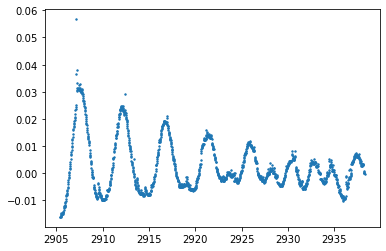

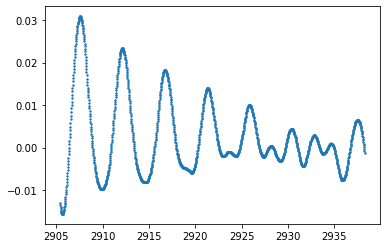

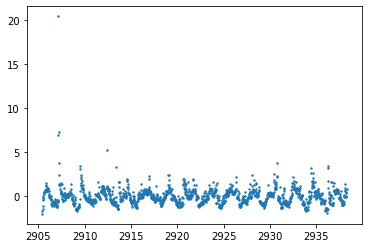

In [6]:
plt.scatter(x, norm_flux, s=2)
plt.show()

plt.scatter(x, np.array(preds_pre.flux_norm), s=2)
plt.show()

plt.scatter(x, y, s=2)
plt.show()

In [7]:
print(len(preds))
print(len(preds_pre)+len(preds_post)+len(preds_postgap))
print(len(pre)+len(post)+len(postgap))
print(len(preds_pre), len(preds_post), len(preds_postgap))
print(len(pre), len(post), len(postgap))
print(len(preds.loc[:len(pre)-1]), len(preds.loc[len(pre)+1:len(pre)+len(post)]),
     len(preds.loc[len(pre)+len(post):]))

3253
3253
3253
1511 671 1071
1511 671 1071
1511 671 1071


In [8]:
print(len(df))

3255


### 3) Run flare models based on xoflares

Ripped off completely from Tom Barclay's xoflares: https://github.com/mrtommyb/xoflares

In [9]:
# this is the flare model implemented in theano
def get_light_curve(time, tpeaks, fwhms, ampls, texp=None, oversample=7):
    time = time.astype('float64')
    time = tt.as_tensor_variable(time)
    
    if texp is None:
        tgrid = time
    if texp is not None:
        # taking this oversample code from
        # https://github.com/dfm/exoplanet
        # and https://github.com/lkreidberg/batman
        oversample = int(oversample)
        oversample += 1 - oversample % 2
        dt = np.linspace(-texp / 2., texp / 2.,
                         oversample)
        tgrid = tt.shape_padright(time) + dt
        
    multiflare_lc = multiflaremodel(tgrid, tpeaks, fwhms, ampls)
    
    if texp is not None:
        multiflare_lc = tt.mean(tt.reshape(multiflare_lc, (-1, oversample)),
            axis=1)

    return multiflare_lc

def multiflaremodel(t, tpeaks, fwhms, ampls):
    t = t.astype('float64')
    t = tt.as_tensor_variable(t)
    multiflare_lc = tt.zeros_like(t)
    flare_lc = tt.zeros_like(t)
    
    def scan_func(tpeak, fwhm, ampl):
        zeropad_flare_lc = tt.zeros_like(t)
        tcut = (((t - tpeak)/fwhm > -1.) * ((t - tpeak)/fwhm < 20.)).nonzero()
        flare_lc = _flaremodel(t[tcut], tpeak, fwhm, ampl)
        zeropad_flare_lc = tt.set_subtensor(zeropad_flare_lc[tcut],  flare_lc)
        return zeropad_flare_lc
    
    components, updates = theano.scan(fn=scan_func,
                                      sequences=[tpeaks, fwhms, ampls],
                                      )
    multiflare_lc = tt.sum(components, axis=0)
    
#     for i in range(npeaks):
#         tcut = (((t - tpeaks[i])/fwhms[i] > -1.) * ((t - tpeaks[i])/fwhms[i] < 20.)).nonzero()
#         flare_lc = _flaremodel(t[tcut], tpeaks[i], fwhms[i], ampls[i])
#         multiflare_lc = tt.set_subtensor(multiflare_lc[tcut],  multiflare_lc[tcut] + flare_lc)
    return multiflare_lc

def _flaremodel(t, tpeak, fwhm, ampl):
    # reuses some code from AltaiPony and Apaloosa
    t = tt.as_tensor_variable(t)
    flare_lc = tt.zeros_like(t)
    flare_lc = tt.where((t <= tpeak) * ((t - tpeak)/fwhm > -1.),
                        before_flare(t, tpeak, fwhm, ampl),
                        flare_lc
                       )
    flare_lc = tt.where((t > tpeak) * ((t - tpeak)/fwhm < 20.),
                        after_flare(t, tpeak, fwhm, ampl),
                        flare_lc
                       )
    return flare_lc

def before_flare(t, tpeak, fwhm, ampl):
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    fout = ((_fr[0] + _fr[1] * ((t - tpeak) / fwhm) +
                        _fr[2] * ((t - tpeak) / fwhm)**2. +
                        _fr[3] * ((t - tpeak) / fwhm)**3. +
                        _fr[4] * ((t - tpeak) / fwhm)**4. ) *
                        ampl)
    return fout

def after_flare(t, tpeak, fwhm, ampl):
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]
    fout = ((_fd[0] * tt.exp( ((t - tpeak) / fwhm) * _fd[1]) +
             _fd[2] * tt.exp( ((t - tpeak) / fwhm) * _fd[3] )) *
            ampl)
    return fout

xx = tt.dvector('xx')
tpeaksx = tt.dvector('tpeaksx')
fwhmsx = tt.dvector('fwhmsx')
amplsx = tt.dvector('amplsx')
#texp = 0.001388888888888889
#multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
#                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx, texp=texp))
theano.config.compute_test_value = 'ignore'

multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx))

In [41]:
# USING GPs TO CALCULATE LIKELIHOODS
with pm.Model() as model:
    npeaks = np.shape(tpeaks)[0]
    mean = pm.Normal("mean", mu=0, sd=3.0, testval=0)
    logs2 = pm.Normal("logs2", mu=np.log(np.var(y)), sd=2.0)

    tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.3,
                      testval=tpeaks, shape=npeaks)
    logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=1.0, testval=np.log(fwhms),
                        shape=npeaks)
    logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=1.0, testval=np.log(ampls),
                        shape=npeaks)

    fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
    ampl = pm.Deterministic("ampl", tt.exp(logAmpl))

    #flare_lc = get_light_curve(x, tpeak, fwhm, ampl, texp=texp, oversample=15)
    flare_lc = get_light_curve(x, tpeak, fwhm, ampl, oversample=15)
    pm.Deterministic("flare_lc", flare_lc)
    pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y)

    #map_soln = xo.optimize(start=model.test_point, vars=[fwhm, mean])
    #map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
    #map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
    #map_soln = xo.optimize(start=map_soln, vars=[tpeak])

    approx = pm.MeanField()
    pm.fit(method=pm.KLqp(approx), n=100000,
            obj_optimizer=pm.adagrad_window
        )
    start = approx.sample(draws=4, )
    start = list(start)
    stds = approx.bij.rmap(approx.std.eval())
    cov = model.dict_to_array(stds) ** 2
    potential = quadpotential.QuadPotentialDiag(cov)

Finished [100%]: Average Loss = 2,700.7


In [23]:
# make a fine grid that spans the observation window for plotting purposes
t_plot = np.linspace(x.min(), x.max(), 5000)

with pm.Model() as model:
    npeaks = np.shape(tpeaks)[0]
    mean = pm.Normal("mean", mu=0, sd=3.0, testval=0)
    logs2 = pm.Normal("logs2", mu=np.log(np.var(y)), sd=1.0)
    
    tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.03, # was *0.003
                      testval=tpeaks, shape=npeaks)
    logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=1.0, testval=np.log(fwhms),
                        shape=npeaks)
    logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=1.0, testval=np.log(ampls),
                        shape=npeaks)
    
    fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
    ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
    
    #flare_lc = get_light_curve(x, tpeak, fwhm, ampl, texp=texp, oversample=15)
    flare_lc = get_light_curve(x, tpeak, fwhm, ampl, oversample=15)
    flare_lc_pred = get_light_curve(t_plot, tpeak, fwhm, ampl, oversample=7) # this one's for plotting only
    pm.Deterministic("flare_lc", flare_lc)
    pm.Deterministic("flare_lc_pred", flare_lc_pred) # this one's for plotting only
    pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y)
    
    #map_soln = xo.optimize(start=model.test_point, vars=[1/fwhm, mean])
    #map_soln = xo.optimize(start=map_soln, vars=[1/ampl, mean])
    #map_soln = xo.optimize(start=map_soln, vars=[1/fwhm, 1/ampl])
    #map_soln = xo.optimize(start=map_soln, vars=[tpeak])
    
    approx = pm.MeanField()
    pm.fit(method=pm.KLqp(approx), n=3000000, 
            obj_optimizer=pm.adagrad_window
        )
    start = approx.sample(draws=4, )
    start = list(start)
    stds = approx.bij.rmap(approx.std.eval())
    cov = model.dict_to_array(stds) ** 2
    potential = quadpotential.QuadPotentialDiag(cov)

Finished [100%]: Average Loss = 1,545.3


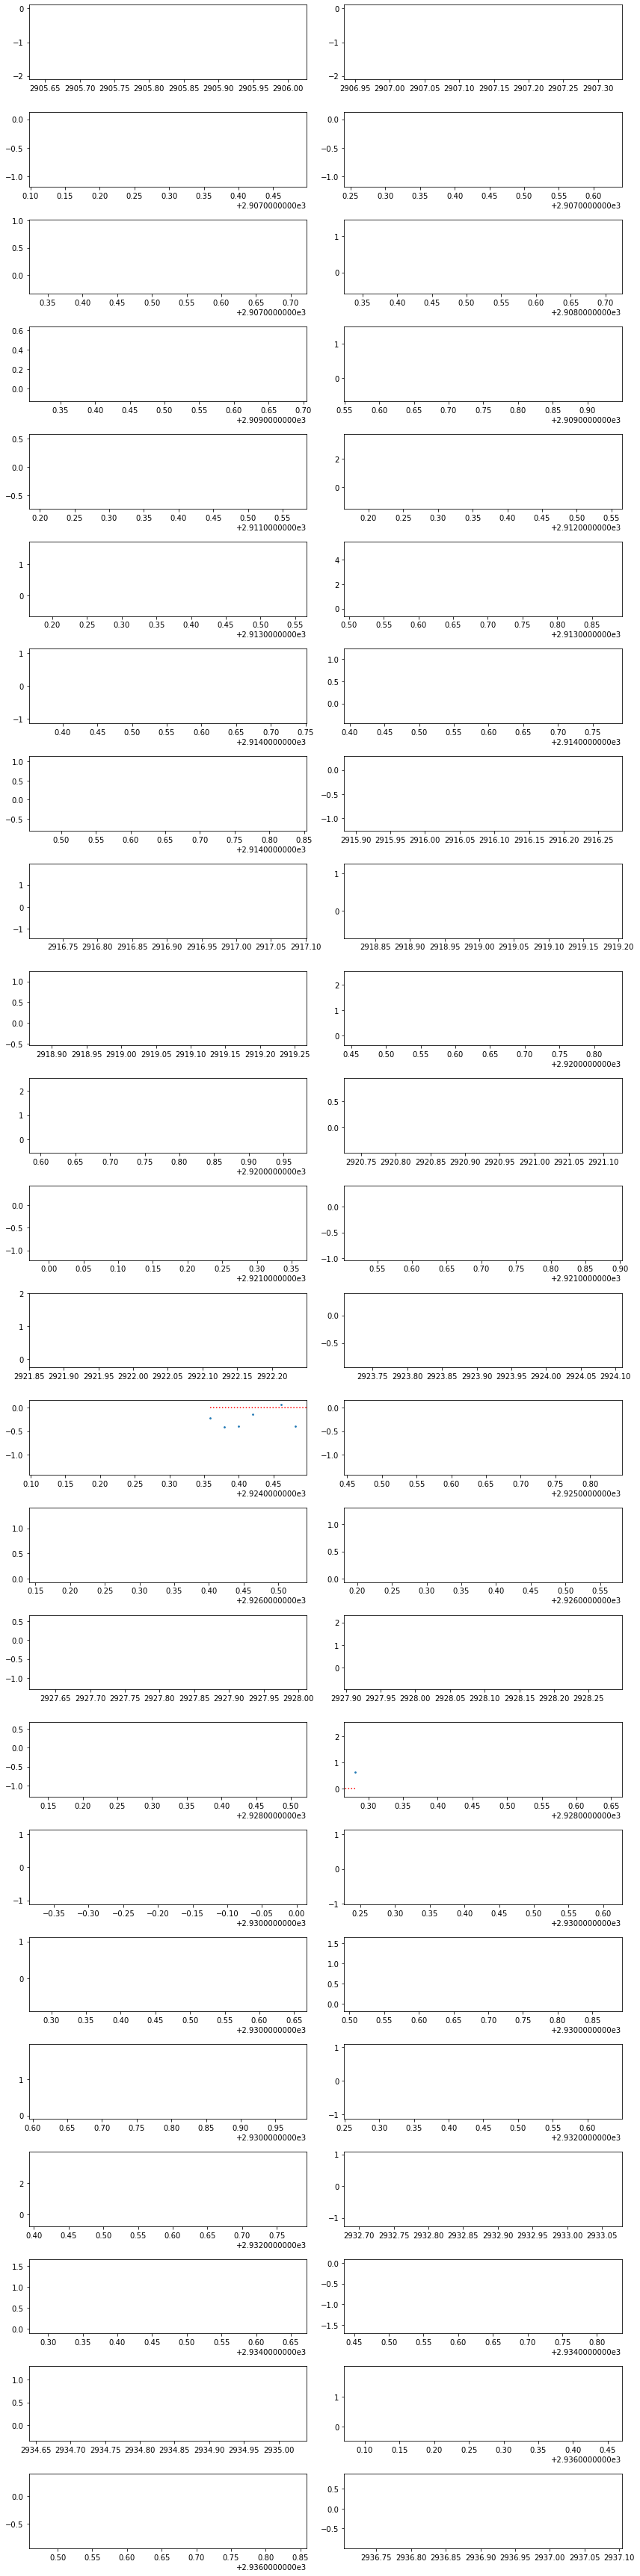

In [42]:
import warnings
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
tps = start[0]['tpeak']
for i in range(npeaks):
    timemask = (x >= tps[i]-0.2) * (x < tps[i]+0.2) # true for values within +/- 0.2 of peak indices
    ax = axes[i]
    ax.scatter(x[timemask], y[timemask], s=3)
    ax.plot(x[timemask], start[0]['flare_lc'][timemask], ':r')
    #ax.scatter(tpeaks[i], ampls[i])
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    #ax.set_ylim(np.min(y[timemask]), np.max(y[timemask]))
fig.tight_layout()

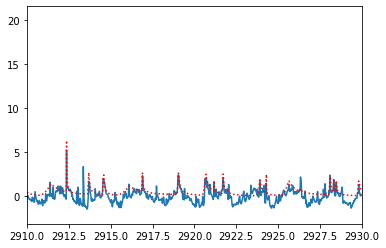

In [26]:
#fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
#axes = axes.flatten()
#tps = start[0]['tpeak']
plt.plot(x, y)
plt.plot(x, start[0]['flare_lc'], ':r')
plt.xlim(2910, 2930)
plt.show()

In [27]:
with model:
    step = pm.NUTS(potential=potential, target_accept=0.9)
    trace = pm.sample(draws=2400, tune=200, step=step, start=start, cores=4)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logAmpl, logFwhm, tpeak, logs2, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 200 tune and 2_400 draw iterations (800 + 9_600 draws total) took 7276 seconds.
The acceptance probability does not match the target. It is 0.9705723502112779, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9593972085677925, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 746 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8028996198649176, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 730 divergences after 

In [29]:
pm.summary(trace, ['logAmpl', 'logFwhm', 'tpeak', 'logs2', 'mean'], )

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
logAmpl[0],0.722,0.147,0.464,0.966,0.061,0.045,6.0,29.0,1.68
logAmpl[1],4.548,0.234,4.277,4.938,0.100,0.075,5.0,21.0,1.98
logAmpl[2],0.792,0.122,0.563,1.024,0.015,0.011,63.0,231.0,1.05
logAmpl[3],0.152,0.864,-1.631,1.586,0.092,0.065,89.0,173.0,1.04
logAmpl[4],0.086,0.951,-1.433,1.869,0.254,0.184,14.0,142.0,1.21
...,...,...,...,...,...,...,...,...,...
tpeak[45],2936.277,0.001,2936.275,2936.279,0.000,0.000,20.0,62.0,1.15
tpeak[46],2936.654,0.010,2936.640,2936.679,0.002,0.002,17.0,15.0,1.26
tpeak[47],2936.962,0.027,2936.903,2937.005,0.010,0.008,8.0,15.0,1.48
logs2,-0.344,0.024,-0.378,-0.298,0.011,0.008,5.0,12.0,2.01


A single flare model

[]

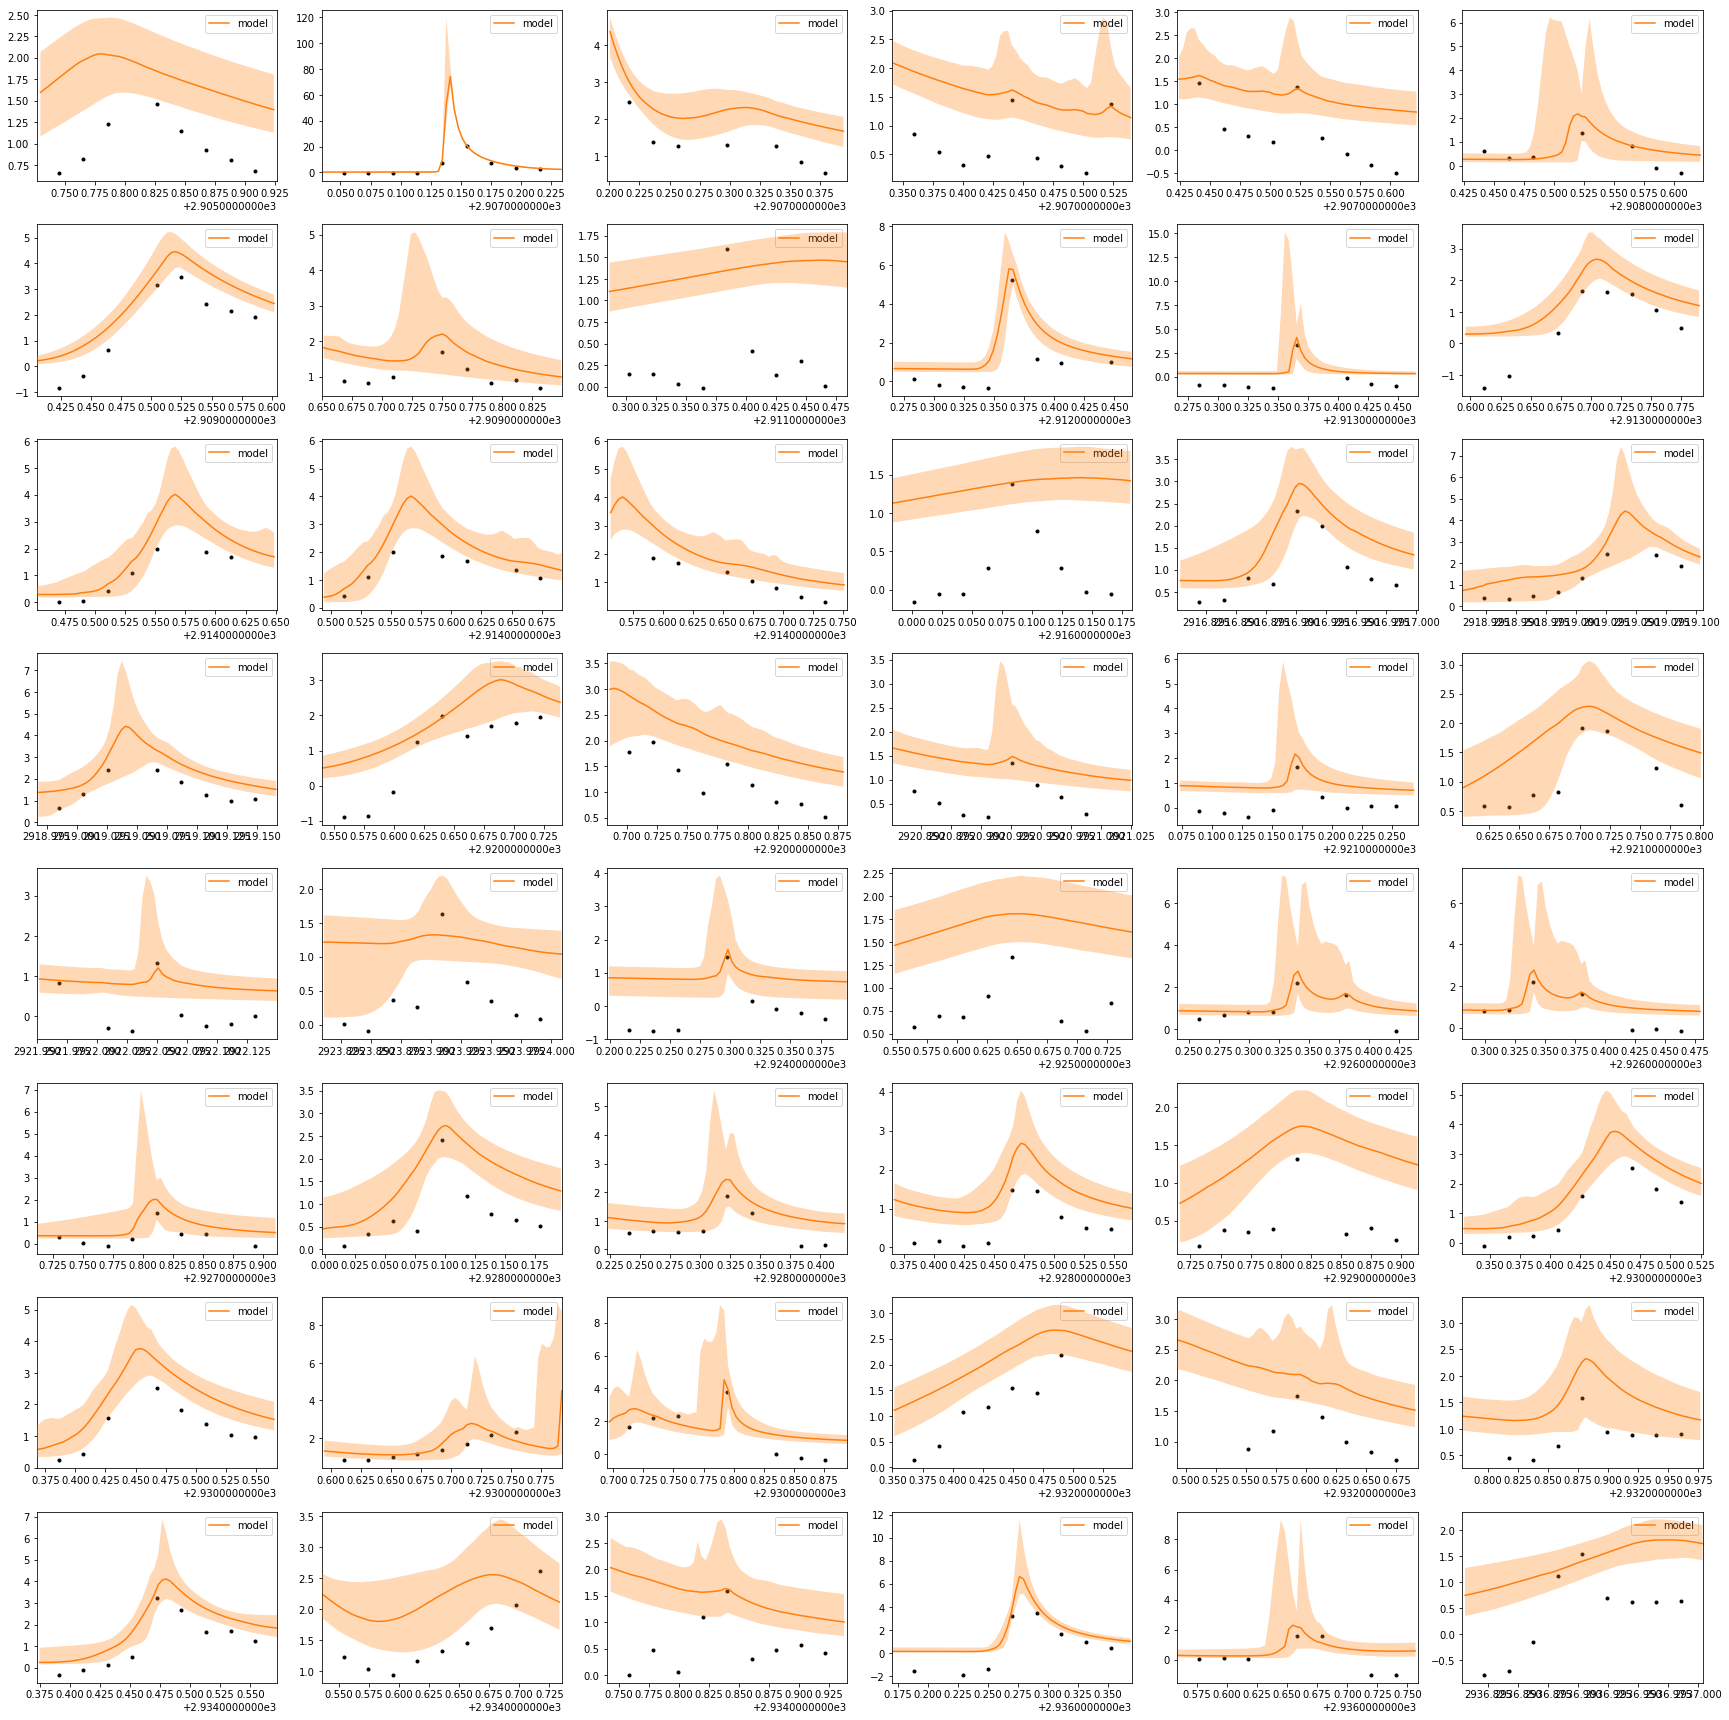

In [65]:
flc_plot =  np.percentile(trace['flare_lc_pred'], [5, 50, 95], axis=0)
flc =  np.percentile(trace['flare_lc'], [5, 50, 95], axis=0)
fig, axes = plt.subplots(ncols=6, nrows=np.ceil(npeaks/6).astype(int), figsize=[24,24])
axes = axes.flatten()
for i in range(npeaks):
    timemask_t_plot = (t_plot >= tpeaks[i]-0.1) * (t_plot < tpeaks[i]+0.1)
    timemask = (x >= tpeaks[i]-0.1) * (x < tpeaks[i]+0.1)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask], '.k')
    ax.plot(t_plot[timemask_t_plot], flc_plot[1][timemask_t_plot], label="model", color="C1")
    art = ax.fill_between(t_plot[timemask_t_plot], 
                          flc_plot[0][timemask_t_plot],
                          flc_plot[2][timemask_t_plot], color="C1", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(tpeaks[i]-0.1, tpeaks[i]+0.1)
    #ax.set_ylim(np.min(y[timemask]) - 1, 1 + np.max(y[timemask]))
    ax.legend()

fig.tight_layout()
#fig.savefig('flare-model.png')
plt.plot()

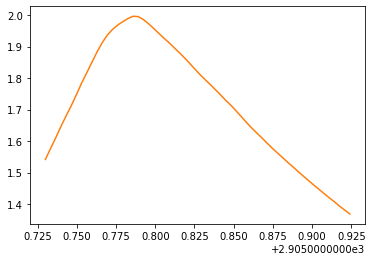

In [34]:
timemask_t_plot = (t_plot >= tpeaks[0]-0.1) * (t_plot < tpeaks[0]+0.1)
plt.plot(t_plot[timemask_t_plot], flc_plot[1][timemask_t_plot], label="model", color="C1")

All the flare models

In [ ]:
import corner

# for some reason, pymc wants to access trace at index 0 when trace starts at 1...so I cheat to make this work
#trace._straces[0] = trace._straces[1]
samples = pm.trace_to_dataframe(trace, varnames=['tpeak', 'ampl', 'fwhm'])
for i in range(trace['tpeak'].shape[1]):
    corner.corner(samples.loc[:,
                              ['tpeak__{}'.format(i), 'ampl__{}'.format(i),
                               'fwhm__{}'.format(i)]], truths=tpeaks);

In [66]:
samples

,tpeak__0,tpeak__1,tpeak__2,tpeak__3,tpeak__4,tpeak__5,tpeak__6,tpeak__7,tpeak__8,tpeak__9,...,fwhm__38,fwhm__39,fwhm__40,fwhm__41,fwhm__42,fwhm__43,fwhm__44,fwhm__45,fwhm__46,fwhm__47
0,2905.782917,2907.140434,2907.331969,2907.447844,2907.480018,2908.523264,2909.513481,2909.734343,2911.430616,2912.364219,...,0.008226,0.199700,0.016757,0.079113,0.111884,0.081793,0.003581,0.027020,0.014610,0.384258
1,2905.785752,2907.140468,2907.334022,2907.450218,2907.475377,2908.522866,2909.512847,2909.730067,2911.426435,2912.364021,...,0.009175,0.195316,0.015689,0.072489,0.113532,0.076123,0.003928,0.026763,0.014156,0.380862
2,2905.782289,2907.140471,2907.334224,2907.453626,2907.480111,2908.525618,2909.512726,2909.729202,2911.430887,2912.363852,...,0.008984,0.195433,0.013838,0.072816,0.114196,0.075821,0.002904,0.027165,0.012922,0.379071
3,2905.782757,2907.140503,2907.334109,2907.445723,2907.461917,2908.523500,2909.513419,2909.727670,2911.444603,2912.363889,...,0.008779,0.206584,0.014005,0.081549,0.112493,0.079183,0.003564,0.026262,0.011939,0.361662
4,2905.781630,2907.140478,2907.332304,2907.435107,2907.452078,2908.523948,2909.514993,2909.732321,2911.449804,2912.364782,...,0.009303,0.212083,0.017459,0.082066,0.108786,0.078513,0.005334,0.026377,0.012330,0.375752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9595,2905.776504,2907.139136,2907.300958,2907.454999,2907.500001,2908.523363,2909.515292,2909.762062,2911.434292,2912.364040,...,0.003546,0.384731,0.003802,0.016667,0.012287,0.395531,0.008992,0.019017,0.008563,0.403508
9596,2905.782067,2907.139155,2907.294291,2907.457363,2907.495739,2908.524694,2909.515768,2909.760804,2911.428995,2912.363575,...,0.003105,0.374917,0.003065,0.018086,0.012155,0.403380,0.008128,0.018758,0.009854,0.389473
9597,2905.780365,2907.139156,2907.293525,2907.458825,2907.493560,2908.525292,2909.515850,2909.761036,2911.428736,2912.363330,...,0.003308,0.375221,0.003202,0.018635,0.012058,0.391544,0.008051,0.018663,0.009697,0.391291
9598,2905.782208,2907.139050,2907.292350,2907.429063,2907.486505,2908.520280,2909.511566,2909.759366,2911.420052,2912.364831,...,0.004074,0.373664,0.004346,0.023588,0.012749,0.363354,0.013338,0.018967,0.008429,0.368786


### 4) Measuring flare energy

From Doyle et al 2018 "Investigating the rotational phase of stellar flares on M dwarfs using K2 short cadence data"

"To determine the energy of the stellar flares, the quiescent luminosity of the star, L_star, must be calculated in the Kepler bandpass. To construct a template spectral energy distribution for each star we used PanStarrs magnitudes g, r, i, and z (see Table A1). The PanStarrs magnitudes (Chambers et al. 2016) represent the mean quiescent magnitude of the star calculated over an average of multiple measurements. This ensures the effects of flares or rotation has been removed from the magnitudes. We fitted a polynomial to the Panstarrs data and determined the flux in the Keplerbandpass in the same manner as Kowalski et al. (2013). The quiescent luminosity is then computed by multiplying the flux by 4πd2, where the distance (d) to the stars has been determined by inverting the parallax from the Gaia Data 2 release (Gaia Collaboration et al. 2016, 2018; see Table 3)...The energy of the flares, Eflare, can then be determined by the multiplication of the luminosity of the star, L*, in erg s−1 and the equivalent duration, t, in seconds. The equivalent duration (Gershberg 1972) is defined as the area under the flare light curve in units of seconds"

OR, from Davenport 2016 "THE KEPLER CATALOG OF STELLAR FLARES": 

"For this reason it better to not assume a single flare spectrum, and instead I estimate the distance and luminosity for each star to determine it’s quiescent luminosity. The Kepler Input Catalog provides ground-based photometry for all available stars in the Kepler field of view. Using Version 10 of this catalog , I obtained the g, Ks, and Kp (Kepler) photometry for every star in the sample. The g − Ks color is then used to place each star on to a stellar isochrone model, which gives an absolute magnitude and mass for each star. Typical photometric uncertainties from the g − Ks color propagate to mass uncertainties of ∼0.02 M_star. This assumes that all stars in the sample are on the isochrone’s main sequence. A 1- Gyr isochrone from the PARSEC models (Bressan et al. 2012) with Z=0.019 and no dust extinction is used. Note this will yield an incorrect distance for giant and subgiant stars. The star’s absolute g, Ks, and Kp (Kepler) magnitudes are determined by linearly interpolating the observed g − K color to the gridded values from the isochrone. The apparent Ks magnitude for each star is used to determine the distance modulus. The isochronederived absolute Kp magnitude is finally converted from AB magnitudes to a quiescent luminosity, which is denoted LKp, and is used to convert flare ED’s to energies. The resulting flare energy that is calculated does not correct for the spectrum of the flare through the Kepler bandpass, or for the flare energy emitted outside the Kepler bandpass, as discussed more in §6."

Get Kepler magnitude
(https://keplerscience.arc.nasa.gov/CalibrationZeropoint.shtml; Smith et al (ApJ 123, 2121, 2002, Table 7)) 

Convert from AB magnitude to quiescent luminosity
(Davenport 2016; https://www.cfa.harvard.edu/~dfabricant/huchra/ay145/mags.html#conversions; Oke, J.B. 1974, ApJS, 27, 21)

In [45]:
# flare energy = L_star * ed
# ed = area under the curve
# L_star = 4 * pi * d**2 * luminosity_q
# d = 1/parallax
# luminosity_q = average g, r, i, z magnitudes???
g = 12.076
r = 10.864
i = 10.228
parallax = 21.6345 # in milliarcsecs (mas)
distance = 1./(parallax*0.001) # parsecs
#distance = 22.74 # nope, use ExoFOP's value: https://exofop.ipac.caltech.edu/k2/edit_target.php?id=246301900
print(distance)

def calculate_energy():
    #l_star = (4*np.pi*distance**2) * ((g+r+i)/3)
    lkp = (4*np.pi*distance**2) * kepmag_zeropoint_luminosity(g, r) * 4000
    print("log LKp: ", np.log10(lkp))
    ed = 0.5*86400*0.05*12000 # from eyeballing one of the flare triangles above
    print("ED: ", ed)
    return np.log10(lkp*ed) # show order of energy in ergs...needs to be ~>27
 
def kepmag_zeropoint_luminosity(g, r): 
    ### kepmag
    # greater error for M dwarfs w/Teff < 3500 K
    # https://keplerscience.arc.nasa.gov/CalibrationZeropoint.shtml
    if (g-r) <= 0.8:
        kp = 0.2*g + 0.8*r
    else:
        kp = 0.1*g + 0.9*r
    #print("Kp: ", kp)
    
    # nope, use ExoFOP's value: 10.807, https://exofop.ipac.caltech.edu/k2/edit_target.php?id=246301900
    kp = 10.807
    
    ### zeropoint, bolometric correction, and magnitude-to-luminosity formula
    # AB mag to f, then multiply by Kepler filter FWHM of 4000 Angstroms
    # per https://www.cfa.harvard.edu/~dfabricant/huchra/ay145/mags.html#conversions
    # and https://iopscience.iop.org/article/10.1088/0004-637X/797/2/121/pdf
    
    #pre_lkp = 4000 * np.exp(-(kp+48.6)/2.5) # Angstrom * erg/(s*Angstrom*cm^2) # https://www.cfa.harvard.edu/~dfabricant/huchra/ay145/mags.html#conversions
    #pre_lkp = 4000 * np.exp(-(kp+4.81)/2.5) # Angstrom * erg/(s*Angstrom*cm^2) # https://academic.oup.com/mnras/article/433/2/1133/1747991
    l_sun = 3.0128e28 * 1e7 # Watts * 1e7 erg/s per Watt
    pre_lkp = l_sun * np.power(10, 0.4*(4.81-kp)) # Eqn 3 in https://academic.oup.com/mnras/article/433/2/1133/1747991
    pre_lkp = l_sun * np.power(10, 0.4*(-20.24-kp)) # https://iopscience.iop.org/article/10.1088/0004-637X/797/2/121/pdf
    #f12 = 1.74e5 # e-/s, per https://keplergo.arc.nasa.gov/CalibrationSN.shtml
    #pre_lkp = f12 * np.power(10, 0.4*(12-kp))
    print("log pre LKp: ", np.log10(pre_lkp)) # erg/(s*cm^2)
    return pre_lkp
    
print("log flare energy: ", calculate_energy())



46.22246874205551
log pre LKp:  23.060170302672592
log LKp:  31.09114643288431
ED:  25920000.0
log flare energy:  38.504781430082865


#### 4.5) the super-flare

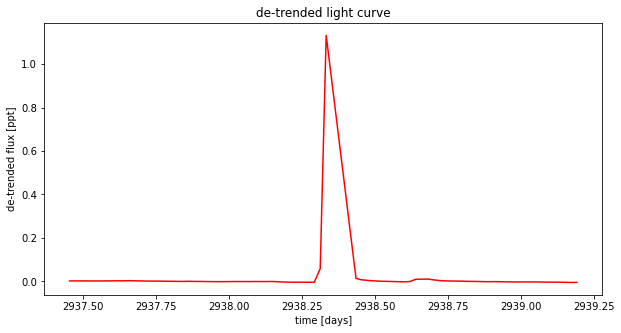

In [49]:
def normalize_flux(flux):
    return flux/np.median(flux) - 1
superflare = df.loc[1569:1655] # area around the superflare

plt.figure(figsize=(10, 5))
#detrended_superflare = superflare.PDCSAP_FLUX-np.ones(len(superflare))*np.median(superflare.PDCSAP_FLUX)
#detrended_superflare = normalize_flux(pd.concat([pre.PDCSAP_FLUX, post.PDCSAP_FLUX, postgap.PDCSAP_FLUX]))
detrended_superflare = normalize_flux(superflare.PDCSAP_FLUX)
plt.plot(superflare.TIME, detrended_superflare, "r")
#plt.plot(superflare.TIME[mask], superflare.PDCSAP_FLUX[mask], "k")
#plt.plot(pre.TIME, smooth)
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("de-trended light curve")
#plt.ylim(580000, 680000)
#plt.xlim(superflare.TIME.min(), superflare.TIME.max())
#plt.savefig('superflare.png')
plt.show()

In [50]:
print(detrended_superflare[39:42])
print(superflare.TIME[39:42])

1612    0.058684
1613    1.132200
1618    0.013559
Name: PDCSAP_FLUX, dtype: float32
1612    2938.313467
1613    2938.333899
1618    2938.436057
Name: TIME, dtype: float64


Hold up...so the superflare is just a single data point? Could this be a systematics/cosmic ray type situation? This introduces challenges with calculating the equivalent duration and therefore the flare's energy. 

In [51]:
superflare_ed = np.trapz(detrended_superflare[39:42], superflare.TIME[39:42]*86400)
print(superflare_ed)

6107.628352754084


### 5) Flare frequency distribution

In [52]:
superflare_ed = np.trapz(detrended_superflare[39:42], superflare.TIME[39:42]*86400)
print(superflare_ed)

6107.628352754084


In [72]:
# get equivalent durations
ed_data = []
ed_model = []
ed_minus = []
ed_plus = []
for i in range(npeaks):
    timemask = (x >= tpeaks[i]-0.2) & (x < tpeaks[i]+0.2)
    ed_data.append(np.trapz(y[timemask]*86400, x[timemask]))
    ed_model.append(np.trapz(flc[1][timemask]*86400, x[timemask]))
    ed_minus.append(np.trapz(flc[0][timemask]*86400, x[timemask]))
    ed_plus.append(np.trapz(flc[2][timemask]*86400, x[timemask]))
    
print(ed_data)
print(ed_model)

# and multiply with quiescent luminosity to get flare energies

[25511.60863275719, 68601.98463793671, 93268.31081890794, 19192.460773538623, 8750.56644321343, 7482.38249500859, 25692.640608658057, 30495.901567995435, 6325.59817728598, 22119.716561561232, -16013.114348784264, -4705.557151780003, 24983.934059076695, 26413.235596948027, 27458.115225779075, 3651.787653268375, 21201.506887394276, 32767.148465302904, 33991.35598514434, 19106.94009109253, 35627.55703976545, 18107.735488414386, 6053.186582217411, 23410.666643240962, 5684.811717474565, 12883.425385002765, 3042.66405059206, 20470.38817976184, 19152.740910480257, 16733.749787822122, 4372.065303694782, 15937.653774602219, 22170.250819258872, 19636.878486365, 6812.073585172874, 26479.50452059221, 28948.313370336356, 42218.17307656632, 30640.327883774175, 30711.904434144915, 36219.437754358834, 23095.522383021635, 25535.53180474156, 44874.73279542729, 24424.04068773849, -7815.153198616231, -4965.398275646529, 2509.673258014406]
[47570.223362923796, 98148.6184232385, 122480.37443175768, 49066.64

In [73]:
def calculate_energy(kp, zeropoint, ed_model):
    l_sun = 3.0128e28 * 1e7 # Watts * 1e7 erg/s per Watt
    pre_lkp = l_sun * np.power(10, 0.4*(zeropoint-kp)) # https://iopscience.iop.org/article/10.1088/0004-637X/797/2/121/pdf
    print("log pre LKp: ", np.log10(pre_lkp)) # erg/(s*cm^2)
    lkp = (4*np.pi*distance**2) * pre_lkp * 4000
    print("log LKp: ", np.log10(lkp))
    print("ED: ", ed_model)
    try:
        return np.log10(lkp*ed_model)
    except:
        return np.log10([lkp*ed for ed in ed_model]) # show order of energy in ergs

# use kepmag value from exofop: https://exofop.ipac.caltech.edu/k2/edit_target.php?id=246301900
flare_energies = calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=ed_model)
flare_energies_minus = calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=ed_minus)
flare_energies_plus = calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=ed_plus)

# add the superflare
flare_energies = np.append(flare_energies, calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=superflare_ed))
print("log flare energy: ", np.sort(flare_energies))

log pre LKp:  23.060170302672592
log LKp:  31.09114643288431
ED:  [47570.223362923796, 98148.6184232385, 122480.37443175768, 49066.643774446726, 38992.785049411694, 18237.34769752724, 56967.28683538758, 50331.02517490404, 38541.35766568547, 42187.69217500253, 20923.982078649857, 31921.564110613625, 41685.56364771676, 43736.78902178406, 46000.88656986986, 40477.58423447648, 39564.276043862425, 51333.58982665306, 55598.022207298796, 48912.653627383996, 59662.38013278018, 43494.38334436339, 28825.212772676445, 43637.52417782884, 25470.045815569832, 36506.53401377908, 28083.432355081404, 49469.86141123297, 35883.03306968699, 35025.078062681954, 18749.025668943294, 37267.27712767423, 44854.19671287234, 41611.28479932748, 34540.29592286772, 45944.11482525147, 48115.97491182533, 59384.01212093144, 51532.80456304656, 56292.781563962744, 59842.611950250764, 42826.5218054721, 48860.02234046999, 72250.15479462805, 49355.18039370477, 31359.311194122616, 21537.65385465218, 39414.80318917749]
log pr

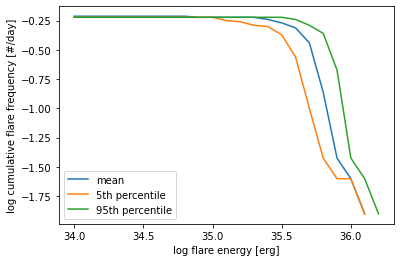

In [81]:
hist, edges = np.histogram(flare_energies, bins=np.linspace(34.0, 37.0, 31))
hist_minus, edges_minus = np.histogram(flare_energies_minus, bins=np.linspace(34.0, 37.0, 31))
hist_plus, edges_plus = np.histogram(flare_energies_plus, bins=np.linspace(34.0, 37.0, 31))

#plt.scatter(edges[:-1], np.log10(hist/80)) # divided by time series length of 80 days
#plt.scatter(edges[:-1], np.log10(np.cumsum(hist[::-1])[::-1]/80)) # cumulative sum; invert order b/c they count from highest bin
#plt.scatter(edges_minus[:-1], np.log10(np.cumsum(hist_minus[::-1])[::-1]/80), marker='v') # cumulative sum; invert order b/c they count from highest bin
#plt.scatter(edges_plus[:-1], np.log10(np.cumsum(hist_plus[::-1])[::-1]/80), marker='^') # cumulative sum; invert order b/c they count from highest bin
plt.plot(edges[:-1], np.log10(np.cumsum(hist[::-1])[::-1]/80), label='mean') # cumulative sum; invert order b/c they count from highest bin
plt.plot(edges_minus[:-1], np.log10(np.cumsum(hist_minus[::-1])[::-1]/80), label='5th percentile') # cumulative sum; invert order b/c they count from highest bin
plt.plot(edges_plus[:-1], np.log10(np.cumsum(hist_plus[::-1])[::-1]/80), label='95th percentile') # cumulative sum; invert order b/c they count from highest bin
plt.ylabel('log cumulative flare frequency [#/day]')
plt.xlabel('log flare energy [erg]')
plt.legend()
#plt.savefig('ffd.pdf', bbox_inches='tight')
plt.show()